In [2]:
import numpy as np
import torch

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Exploration:

In [3]:
import pandas as pd

df = pd.read_csv('../data/raw/train.csv')
df.head()                       # returns the first 5 rows of pandas DataFrame 'df'

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
df.shape

(120000, 3)

*Note.* &nbsp;&nbsp;&nbsp;&nbsp; We have 120 000 tuples or a DataFrame with 120 000 rows and 3 columns for `Class Index `, `Title`, and `Description`.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Then we do not have any missing values (all tuples have max info).

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.countplot(df['Class Index'])
# plt.xlabel('Class')                 # NOTE: DO NOT run again (takes forever)

Then also notice that we do not have a class imbalance (equal representation in data)

### Data Preprocessing:

In [7]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Here, `bert-base-cased` refers to the base **BERT** model trained on *cased* (upper and lowercase texts) where as `bert-base-uncased` refers to the base BERT model trained on only lowercase texts. The cased version is recommended.

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

sample_txt = 'I am excited for this semester at the University of Florida. Go Gators!'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"Sentence:  {sample_txt}")
print(f"Tokens:    {tokens}")
print(f"Token IDS: {token_ids}")

C:\Projects\news-classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sentence:  I am excited for this semester at the University of Florida. Go Gators!
Tokens:    ['I', 'am', 'excited', 'for', 'this', 'semester', 'at', 'the', 'University', 'of', 'Florida', '.', 'Go', 'G', '##ators', '!']
Token IDS: [146, 1821, 7215, 1111, 1142, 14594, 1120, 1103, 1239, 1104, 2631, 119, 3414, 144, 11664, 106]


*Special Tokens*

In [9]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

&nbsp;&nbsp;&nbsp;&nbsp;&rarr; Marker for ending of a sentence.

In [10]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

&nbsp;&nbsp;&nbsp;&nbsp;&rarr; Marker for classification added to the start of a sentence.

In [11]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

&nbsp;&nbsp;&nbsp;&nbsp;&rarr; Padding token.

In [12]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

&nbsp;&nbsp;&nbsp;&nbsp;&rarr; Unknown token (word or subword not present in `bert-base-cased` original training dataset).

In [13]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,    # referring to adding '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',         # return PyTorch tensors
)

encoding.keys()

# dict_keys(['input_ids', 'attention_mask'])

KeysView({'input_ids': tensor([[  101,   146,  1821,  7215,  1111,  1142, 14594,  1120,  1103,  1239,
          1104,  2631,   119,  3414,   144, 11664,   106,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])})

Notice the presence of *special tokens* after running the `sample_txt` through the `tokenizer` method:
 + '[CLS]' ~ (101) at the start
 + '[SEP]' ~ (102) at the end and
 + '[PAD]' ~ (0) padding indices 17 to 31 with zeros

We have a Tensor storing token ids and padded to a length of 32.

In [14]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,   146,  1821,  7215,  1111,  1142, 14594,  1120,  1103,  1239,
         1104,  2631,   119,  3414,   144, 11664,   106,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

And we have our attention mask, a binary Tensor used for informing the model which tokens in a sequence should be considered during the **attention mechanism** and which should be ignored.

In [15]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'][0]

32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

Inversing tokenization (text -> token ids), we return to our original text-form sequence of tokens.

In [16]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'I',
 'am',
 'excited',
 'for',
 'this',
 'semester',
 'at',
 'the',
 'University',
 'of',
 'Florida',
 '.',
 'Go',
 'G',
 '##ators',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

*Choosing Sequence Length*

Here, `token_lens` is used to store the ordered lengths of descriptions from our training data.

In [17]:
token_lens = []

for txt in df['Description']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

Plotting the distribution,

Text(0.5, 9.444444444444438, 'Token count')

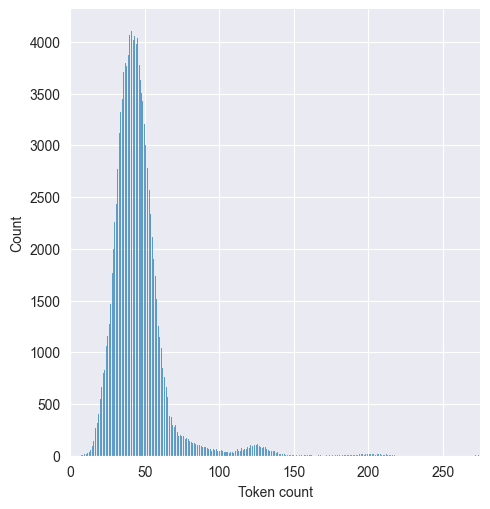

In [18]:
sns.displot(token_lens)
plt.xlim([0, 275])
plt.xlabel('Token count')

We notice that `Description`s are between 40 and 50 tokens on average and upwards of 150 tokens captures nearly all `Description`s. Therefore we choose a `MAX_LEN` of 150 to balance accuracy and efficiency.

In [19]:
MAX_LEN = 150

*Creating custom Dataset class*

In [20]:
from torch.utils.data import Dataset

class NewsArticlesDataset(Dataset):

    def __init__(self, descriptions, targets, tokenizer, max_len):
        self.descriptions = descriptions    # array of inputs
        self.targets = targets              # array of outputs
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, item):
        description = str(self.descriptions[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            description,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'description_text': description,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding ['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

*Note.* &nbsp;&nbsp;&nbsp;&nbsp; Since our `NewsArticleDataset` class inherits from the `Dataset` class of `torch.utils.data`, note that this class requires the following methods:
+ `__len__(self)`: this method returns the total number of samples in the corresponding dataset.
+ `__getitem__(self, item)`: this method enables indexing into the corresponding dataset using `item` parameter, allowing for retrieval of specific samples and their corresponding label (or target).

*Splitting the data*

In [21]:
from sklearn.model_selection import train_test_split

# df_train, df_test = train_test_split(
#     df,
#     test_size=0.1,
#     random_state=RANDOM_SEED
# )
#
# df_val, df_test = train_test_split(
#     df_test,
#     test_size=0.5,
#     random_state=RANDOM_SEED
# )

However, our datasets have been (conveniently) split into `train.csv` and `test.csv` by the file provider.

In [21]:
import pandas as pd

df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

train_rows = len(df_train)
test_rows = len(df_test)
total_rows = train_rows + test_rows

train_ratio = train_rows / total_rows
test_ratio = test_rows / total_rows

print(f"Train-Test data split: {train_ratio * 100}%, {test_ratio * 100}%")

Train-Test data split: 94.04388714733543%, 5.956112852664576%


In [22]:
from sklearn.model_selection import train_test_split

# extract ~ 5% of training data for validation (for fine-tuning hyperparams)
df_train, df_val = train_test_split(
    df_train,
    test_size=0.05,
    random_state=RANDOM_SEED,
)

train_rows = len(df_train)
val_rows = len(df_val)
test_rows = len(df_test)

total_rows = train_rows + val_rows + test_rows

train_ratio = train_rows / total_rows
val_ratio = val_rows / total_rows
test_ratio = test_rows / total_rows

print(f"Train-Test data split: {train_ratio * 100}%, {val_ratio * 100}%, {test_ratio * 100}%")

Train-Test data split: 89.34169278996865%, 4.702194357366771%, 5.956112852664576%


*Recall*. &nbsp;&nbsp;&nbsp;&nbsp; ML Process can be broken in the following stages:
1. Training (where model learns patterns, relationships, and parameters from training data)
2. Validation (used for fine-tuning of hyperparameters and selecting best performing model architecture)
3. Testing (dataset independent of training and validation datasets; purpose of providing unbiased evaluation of the final selected model's performance on "unknown" data, a simulation for real-world use)

In [23]:
print("Original class ranges:")
print(f"Train: {df_train['Class Index'].min()} to {df_train['Class Index'].max()}")
print(f"Val: {df_val['Class Index'].min()} to {df_val['Class Index'].max()}")
print(f"Test: {df_test['Class Index'].min()} to {df_test['Class Index'].max()}")

df_train['Class Index'] = df_train['Class Index'] - 1
df_val['Class Index'] = df_val['Class Index'] - 1
df_test['Class Index'] = df_test['Class Index'] - 1

print("\nConverted to 0-indexed:")
print(f"Train: {df_train['Class Index'].min()} to {df_train['Class Index'].max()}")
print(f"Val: {df_val['Class Index'].min()} to {df_val['Class Index'].max()}")
print(f"Test: {df_test['Class Index'].min()} to {df_test['Class Index'].max()}")

Original class ranges:
Train: 1 to 4
Val: 1 to 4
Test: 1 to 4

Converted to 0-indexed:
Train: 0 to 3
Val: 0 to 3
Test: 0 to 3


*Note.* &nbsp;&nbsp;&nbsp;&nbsp; The above conversion is required since we are using *Cross Entropy* loss which expects targets in the range [0, `n_classes` - 1].

*Data Loaders*

In [24]:
from torch.utils.data import DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsArticlesDataset(
        descriptions=df['Description'].to_numpy(),
        targets=df['Class Index'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0               # NOTE: Causes errors on Windows unless zero
    )

*Note.* &nbsp;&nbsp;&nbsp;&nbsp; PyTorch's `DataLoader` module has a well-known issue where the `num_workers` parameter must be set to zero on Windows devices, otherwise breaking errors ensue.

In [25]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Taking a closer look at an example batch from our training data loader,

In [26]:
data = next(iter(train_data_loader))

print("Keys in batch:", data.keys())
print("Input IDs shape:", data['input_ids'].shape)
print("Attention mask shape:", data['attention_mask'].shape)
print("Targets shape:", data['targets'].shape)

Keys in batch: dict_keys(['description_text', 'input_ids', 'attention_mask', 'targets'])
Input IDs shape: torch.Size([16, 150])
Attention mask shape: torch.Size([16, 150])
Targets shape: torch.Size([16])


**Topic Classifier Class**

In [27]:
from transformers import BertModel

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

*Recall*. &nbsp;&nbsp;&nbsp;&nbsp; `PRE_TRAINED_MODEL_NAME` corresponds with `bert-base-cased`.

In [28]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask'],
    return_dict=False                           # used to return a tuple
)

Here, `last_hidden_state` is a sqeuence of hidden states of the last layer of the model. The `pooled_output` is obtained by applying the *BertPooler* on `last_hidden_state`.

In [66]:
last_hidden_state.shape

torch.Size([1, 32, 768])

That is we have a tensor 2D (32 x 768) tensor storing 768 hidden states for each of the 32 tokens (limited to 32 previously). We can verify the number of hidden states or hidden units in the feedforward networks with the following:

In [67]:
bert_model.config.hidden_size

768

Lastly, `pooled_output` acts as a summary of the content after passing through the **BERT** model.

In [68]:
pooled_output.shape

torch.Size([1, 768])

*Classifier*

In [29]:
from torch import nn

class TopicClassifier(nn.Module):

    def __init__(self, n_classes):
        super(TopicClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.5) # probability of dropping
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )

        output = self.drop(pooled_output)

        return self.out(output)

This class is compromised of two components:
1. `def __init__(self, n_classes)`:
    + `self.bert` represents our pretrained model from which we base the transfer learning off of. BERT provides:
        + 12 transformer layers (`bert-base`)
        + 768-dimensional representations
        + pre-learned linguistic patterns, grammars and some world knowledge
    + `self.drop` represents the *dropout layer* which prevents overfitting by randomly dropping 30% (since `p=0.3`) of neurons (that is randomly zeroing `pooled_output` values) during training.
        + *Note*. &nbsp;&nbsp; process of randomly dropping neurons during training is referred to as **regularization**.
    + `self.out` represents the *classification head* providing a single linear layer with input dimension of 768 (corresponding to **BERT**'s hidden size) and an output dimension corresponding to `n_classes` to classified into.
2. `def forward(self, input_ids, attention_mask)`:
    + takes in a sequence of token ids and an attention mask for a given batch of texts
    + processes through BERT (12 transformer layers)
    + returns:
        + `last_hidden_layer` of form [batch, seq_len, 768] and corresponding to all token representations
        + `pooled_output` of the form [batch, 768], this is the [CLS] token with an additional pooling layer (linear layer + tanh used to further refine given representation).
    + *Note*. &nbsp;&nbsp; The [CLS] token is specifically designed for sentence-level tasks, so it makes sense to use pooled_output.
    + Classification here takes on a linear transformation:
        + [batch, 768] -> [batch, n_classes]

*Creating an Instance of the Model*

First, we'll move an example batch of training data to the GPU.

In [30]:
model = TopicClassifier(4) # for topics of "sports", "business", "sci"/"tech" and                           # "world"
model = model.to(device)

In [31]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(f"Input IDs shape: {input_ids.shape}")
print(f"Attention mask shape: {attention_mask.shape}")

Input IDs shape: torch.Size([16, 150])
Attention mask shape: torch.Size([16, 150])


To get the predicted probabilities from our trained model, we apply the `softmax` function to the outputs:

In [32]:
import torch.nn.functional as F

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1700, 0.1185, 0.5339, 0.1776],
        [0.1860, 0.2171, 0.4404, 0.1565],
        [0.2085, 0.2092, 0.3769, 0.2054],
        [0.0991, 0.2078, 0.5346, 0.1585],
        [0.2434, 0.4212, 0.1639, 0.1715],
        [0.2879, 0.1365, 0.2290, 0.3465],
        [0.1734, 0.3336, 0.3245, 0.1685],
        [0.2916, 0.2144, 0.3916, 0.1024],
        [0.2711, 0.2648, 0.3253, 0.1389],
        [0.2574, 0.2044, 0.2942, 0.2439],
        [0.1551, 0.1712, 0.4730, 0.2006],
        [0.3438, 0.1614, 0.1309, 0.3639],
        [0.1963, 0.4087, 0.3349, 0.0601],
        [0.1236, 0.3870, 0.4390, 0.0504],
        [0.2348, 0.1400, 0.5451, 0.0801],
        [0.3006, 0.1247, 0.4642, 0.1105]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

### Training

In [33]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
print(total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

71250


*Note.* &nbsp;&nbsp;&nbsp;&nbsp; Adaptive Moment Estimation (Adam) combines the best of RMSprop and momentum. In particular, `AdamW` fixes the standard Adam's incorrect application of *weight* to the adaptive learning rate. This is done by decoupling weight decay from gradient-based updates.

Moreover, notice the following hyperparameter:
+ `lr=2e-5` represents the "magic number" proven to be the best for BERT fine-tuning

The schedule profile is created with `get_linear_schedule_with_warmup`. The *no warmup* qualifier refers to immediate start of this process at the learning rate of `lr=2e-5`. (Alternatively, using 10 percent of the `total_steps` for a warmup is typical).
+ Warmups are most beneficial when training a model from scratch, however for fine-tuning purposes this becomes less critical.
    + (Ex.) For 1000 batches / epoch * 10 epochs we have the following.
        + *Step 0:* &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $lr = 2e^{-5}$
        + &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...
        + *Step 5 000:* &nbsp;&nbsp;&nbsp;&nbsp; $lr = 1e^{-5}$
        + &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...
        + *Step 10 000:* &nbsp;&nbsp; $lr = 0$

The *loss function* (`loss_fn`) uses the `CrossEntropyLoss` method of `torch.nn`. This method combines **LogSoftmax** and **NLLLoss** into a single operation.
+ *Recall*. The general **softmax** function takes an array of arbitrary real numbers and convert them into a probability distribution over multiple classes.
+ **NLLLoss** refers to the "negative log-likelihood loss" function which takes in (given through a forward call) log-probabilities of each available class.
+ Combination of operations produces single operation which is generally more stable than its subparts.

*Training Helper Function*

In [34]:
def train_epoch(
        model,
        data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        n_examples
):
    model = model.train()   # enables dropout layers
                            # enables batch normalization

    # initialize tracking
    losses = []
    correct_predictions = 0

    # main loop to handle batches
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        # NOTE: Moving tensors from CPU to GPU is critical for perf (100x speedup!)

        # forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # predictions and loss
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, targets)

        # update metrics
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # backwards pass/backpropagation
        loss.backward()         # calculates gradient
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # gradient clipping
        optimizer.step()        # update weights
        scheduler.step()        # update leaning rate
        optimizer.zero_grad()   # reset gradients for next batch

    return correct_predictions.double() / n_examples, np.mean(losses)

*Note.* &nbsp;&nbsp;&nbsp;&nbsp; The function `train_epoch` returns the ratio of correct predictions or the model's *accuracy* and the average *loss* encountered across training batches. The use of the built-in function `double` converts correct_predictions to a float datatype.

Here, we perform model training through the following steps:
1. **Forward Pass:** Here we pass our *training data* (in batches of 16 texts) through the 12 layers of BERT. The result of this is stored in `outputs` storing value-index pairs.
2. **Calculate Loss:** The `loss_fn` function takes raw logits (`outputs`) and true labels (`targets`) and computes *cross-entropy* for each sample, averaging across the batch. The parameter `dim=1` passed into the `torch.max` method corresponds with the predictions occurring along the single dimension of classes ("world", "business", "sports", "science").
3. **Backward Pass (Backpropagation):** This step entails: computing gradients -> clipping these gradients (meaning normalizing to values between 0 and 1) -> updating weights (utilizing `AdamW` algorithm) -> decaying learning rate (via the `scheduler` $2e^{-5} \rightarrow 0$) -> clearing gradients (o.w. gradients accumulates across batches causing incorrect updates).

*Evaluation Helper Function*

In [35]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():   # disables gradient
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            # forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # prediction and loss
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            # update metrics
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

*Note.* &nbsp;&nbsp;&nbsp;&nbsp; Evaluation loop iterations are structured to ensure no gradients, meaning that intermediates are discarded immediately. During evaluation, the weights of the model are not to be altered and thus gradient calculation is redundant. Hence the lack of a *backwards pass*.

Here, we perform model evaluation with the following steps:
1. **Forward Pass:** Here we pass our *training data* through the 12 layers of BERT. The result of this is stored in `outputs` storing value-index pairs.
2. **Calculate Loss:** The `loss_fn` function takes raw logits (`outputs`) and true labels (`targets`) and computes *cross-entropy* for each sample, averaging across the batch. The parameter `dim=1` passed into the `torch.max` method corresponds with the predictions occurring along the single dimension of classes.

*Training Loop*

In [40]:
%%time

from collections import defaultdict

history = defaultdict(list) # stores accuracy and loss training loop values
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print('-' * 10)

    # training
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Training   loss {train_loss}\taccuracy {train_acc}")

    # validation
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Evaluation loss {val_loss}\taccuracy {val_acc}")

    print()

    # update (ordered) accuracy/loss metrics
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '../models/checkpoints/best_model_state.pt')
        best_accuracy = val_acc


Epoch 1/10
----------
Training   loss 0.2510541493680916	accuracy 0.9189561403508771
Evaluation loss 0.1919799305368215	accuracy 0.9369999999999999

Epoch 2/10
----------
Training   loss 0.15897954967390876	accuracy 0.953657894736842
Evaluation loss 0.22889892363951853	accuracy 0.9416666666666667

Epoch 3/10
----------
Training   loss 0.11087216715866766	accuracy 0.9716754385964912
Evaluation loss 0.2543575273696333	accuracy 0.94

Epoch 4/10
----------
Training   loss 0.07951800170442776	accuracy 0.9802280701754386
Evaluation loss 0.3411920076053745	accuracy 0.9383333333333334

Epoch 5/10
----------
Training   loss 0.054706863651763374	accuracy 0.9871052631578947
Evaluation loss 0.3756672451720806	accuracy 0.938

Epoch 6/10
----------
Training   loss 0.039163159063682035	accuracy 0.9910877192982456
Evaluation loss 0.4062681366800486	accuracy 0.9368333333333333

Epoch 7/10
----------
Training   loss 0.02812322039358862	accuracy 0.9935526315789472
Evaluation loss 0.424569637696249	accura

*Note.* &nbsp;&nbsp;&nbsp;&nbsp; When, what is considered a "magic command", `%%time` is placed at the very beginning of a cell in Jupyter Notebooks and IPython consoles, it calculates and displays the *wall time* for all the code within that cell to execute. *Wall time* refers to the actual time elapsed, as measured by a clock on the wall, from the start to the end of execution (including any time spent waiting for I/O and other processes).

*Note.* &nbsp;&nbsp;&nbsp;&nbsp; We use `defaultdict(list)` here instead of the standard Python `dict` since the built-in version requires initialization of each key whereas `defaultdict` auto-initializes keys. The purpose of storing ordered accuracy and loss metrics in the variable `history` from each iteration allow for powerful visualization later on down the line.

*Note.* &nbsp;&nbsp;&nbsp;&nbsp; Notice that at the end of each iteration we save the model only if we have a training pass which is more accurate than those already occurred. This reduces unnecessary/inefficient memory usage. Additionally, the use of `state_dict` saves only the model's state, often requiring less memory than other methods like saving the entire model (model state + dependencies).
+ To load a model which was saved using `state_dict`,
```
# Saving:
# torch.save(model.state_dict(), 'model.bin')

# Loading:
model = TopicClassifier(n_classes)
model.load_state_dict(torch.load('model.bin')
```
Finally, we perform this check using the `val_acc` parameter. This is since the training accuracy (`train_acc`) is expected to improve each iteration, whereas the evaluation accuracy (`val_acc`) measures generalization and thus often improves some iterations while worsening for others. Analogously, training loss (`train_loss`) will gradually decrease and conversely, evaluation loss (`val_loss`) is generally continuous and also less interpretable. This leaves evaluation accuracy as the best choice here!
+ Additionally, decisions should NOT be made based on the test set performance!

*Visualization of Results*

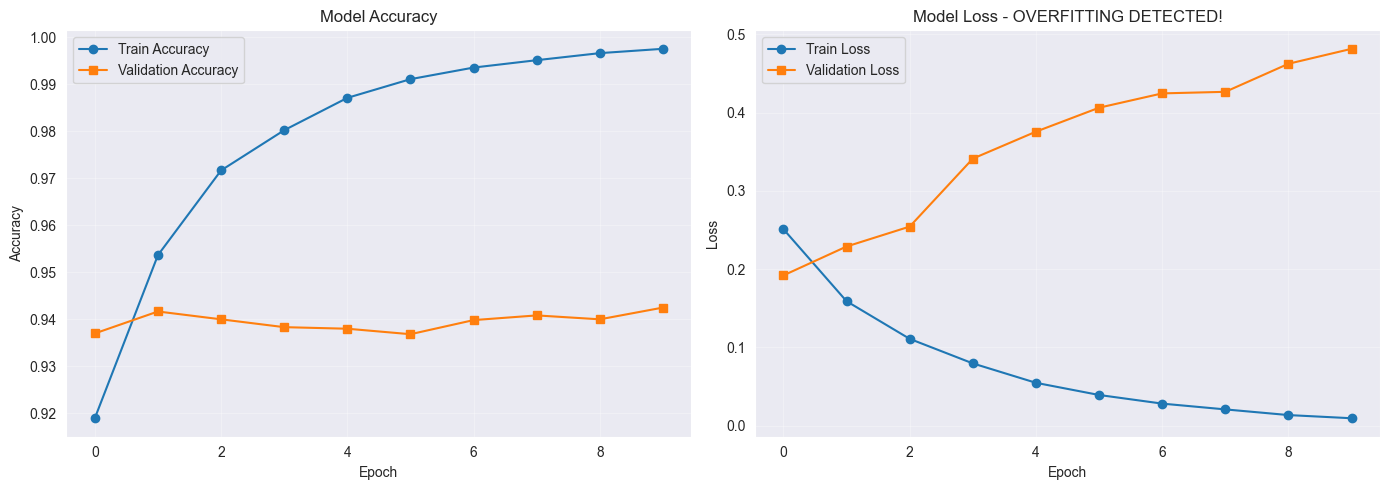

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# convert tensors to numpy arrays helper function
def tensor_to_numpy(values):
    """Convert list of tensors or values to numpy array"""
    result = []
    for v in values:
        if torch.is_tensor(v):
            result.append(v.cpu().numpy() if v.dim() > 0 else v.cpu().item())
        else:
            result.append(v)
    return np.array(result)

# create the plots (using converted tensors)
_, axes = plt.subplots(1, 2, figsize=(14, 5))

# accuracy plot
axes[0].plot(tensor_to_numpy(history['train_acc']), label='Train Accuracy', marker='o')
axes[0].plot(tensor_to_numpy(history['val_acc']), label='Validation Accuracy', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# loss plot
axes[1].plot(tensor_to_numpy(history['train_loss']), label='Train Loss', marker='o')
axes[1].plot(tensor_to_numpy(history['val_loss']), label='Validation Loss', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss - OVERFITTING DETECTED!')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

*Comments on Results*

From the visuals above, we can conclude the following results:
1. Training loss: 0.251 (Epoch 1) $\rightarrow$ 0.009 (Epoch 10)
    + Represents a 96% decrease
2. Validation loss: 0.192 (Epoch 1) $\rightarrow$ 0.482 (Epoch 10)
    + Represents a 151% increase (symptom of *overfitting*)
    + Peak performance occurs during *Epoch 2* (94.17% accuracy)
    + Model begins memorizing training data after we reach this peak performance (logical to reduce epochs for future training)

Regarding the issue of **overfitting** the training data can be addressed for future training in the following ways:
1. *Increasing dropout*. This can be done within the initializer method of the `TopicClassifier` class by changing the value of the `self.drop` parameter (ex. increasing from `p=0.3` to `p=0.5`).
    + Generally dropout rates range from [0.2, 0.5], with rates like 0.5 seen for fully connected layers and rates like 0.1 and 0.2 being more suitable for convolutional layers.
    + The optimal rate is a hyperparameter that depends on the dataset size and model complexity.
    + Higher dropout rates *decrease overfitting* but can slow training/produce **underfitting** while lower rates ofer milder regularization (reduction of overfitting).
2. *Reduce learning rate*. Reducing learning rate by a factor of two for instance ($2e^{-5} \rightarrow 1e{-5}$) within the `optimizer` set up:
    ```
    optimizer = AdamW(model.parameters(), lr=1e-5)
    ```
3. *Use weight decay*. Introducing *weight decay*, a regularization technique that prevents model **overfitting** by discouraging large weights can be done with the following:
    ```
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    ```
4. *Implementing Early Stopping*. Regularization technique used to prevent **overfitting** by monitoring a model's performance on a separate *validation set* during training and halting the training process once performance on the *validation set* starts to degrade. This also saves the model weights (and other state data) from the point of optimal performance.
    ```
    class EarlyStopping:
        patience: int = 3
        min_delta: float = 0.001
        counter: int = 0
        # ...

        def __call__(self, val_loss):
        """dfdfsd"""

        # ...

    # ... in training loop:
    early_stopping = EarlyStopping(patience=3)

    for epoch in range(EPOCHS):
        # ... training code ...

        if early_stopping(val_loss):
            print(f"Early stopping triggered at epoch {epoch}")
            break
    ```

After adjusting the dropout rate to `p=0.5` and implementing an `EarlyStopping` class, we enter the training loop, replicated below:

In [36]:
class EarlyStopping:
    """Early stopping class for preventing model overfitting"""

    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0

    def __call__(self, current_score, model=None):
        """Check if training should be stopped"""
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True

            return False


The initializer method for this class possesses the following attributes:
+ `patience`: representing how many epochs to wait after most recent improvement
+ `counter` and `best_acc` member variables for storing epochs since last improvement and highest `val_acc` value seen so far, respectively.

The caller method:
+ Takes in `current_score` referring to the current epoch's accuracy metric
+ Updates `best_acc` and resets `counter` as a larger accuracies are seen
+ Otherwise, increments `counter` and checks it against `patience` parameter, returning true (and triggering early stop) if exceeding the value of `patience`.

*Preparing GPU for training*

*Note*. &nbsp;&nbsp;&nbsp;&nbsp; Only required once before running all previous cells.


In [1]:
import torch
torch._C._cuda_emptyCache()


print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Memory allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
print(f"Memory reserved: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")
print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/1024**3:.2f} GB")

GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB
Total memory: 6.00 GB


*Training Loop (version 2)*

In [ ]:
%%time

from collections import defaultdict

history = defaultdict(list) # stores accuracy and loss training loop values
best_accuracy = 0

early_stopping = EarlyStopping(patience=3)

for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print('-' * 10)

    # training
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Training   loss {train_loss}\taccuracy {train_acc}")

    # validation
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Evaluation loss {val_loss}\taccuracy {val_acc}")

    # update (ordered) accuracy/loss metrics
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '../models/checkpoints/best_model_state.pt')
        best_accuracy = val_acc

    # check for early stopping
    if early_stopping(val_loss):
        print(f"Early stopping at epoch {epoch + 1}.\t Best accuracy: {best_accuracy:.4f}")
        break

    print()


Epoch 1/10
----------


*Visualization of Results*

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# convert tensors to numpy arrays helper function
def tensor_to_numpy(values):
    """Convert list of tensors or values to numpy array"""
    result = []
    for v in values:
        if torch.is_tensor(v):
            result.append(v.cpu().numpy() if v.dim() > 0 else v.cpu().item())
        else:
            result.append(v)
    return np.array(result)

# create the plots (using converted tensors)
_, axes = plt.subplots(1, 2, figsize=(14, 5))

# accuracy plot
axes[0].plot(tensor_to_numpy(history['train_acc']), label='Train Accuracy', marker='o')
axes[0].plot(tensor_to_numpy(history['val_acc']), label='Validation Accuracy', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# loss plot
axes[1].plot(tensor_to_numpy(history['train_loss']), label='Train Loss', marker='o')
axes[1].plot(tensor_to_numpy(history['val_loss']), label='Validation Loss', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss - OVERFITTING DETECTED!')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

*Commentary on Adjustments*

TODO: Comments

### Testing

*TODO: Subheading*

In [ ]:
test_acc = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_acc.item()